In [1]:
import sys

sys.path.append('../../')

In [2]:
from analysis_functions import test_after_opt, split_transform_one_comp_cv, opener

In [3]:
# Load data
X_stress_components_new = opener(
    "X_stress_components_new_components", path_import="../../new_components_resources/"
)
y_stress_components_new = opener(
    "y_stress_components_new_components", path_import="../../new_components_resources/"
)

print(X_stress_components_new.shape)

component_num = 1
# n_trials = 200

# Проверяем доступность GPU
# use_gpu = torch.cuda.is_available()
# device = "cuda" if use_gpu else "cpu"
# print(f"Используется устройство: {device}")

# Данные для текущего компонента
X_current = X_stress_components_new[component_num]
y_current = y_stress_components_new[component_num]

../../new_components_resources//X_stress_components_new_components.pkl
../../new_components_resources//y_stress_components_new_components.pkl
(3, 1597, 5)


In [4]:
# Example usage:
import sys

sys.path.append('../../')
import torch
from gpu_optuna import do_optuna_pytorch, test_best_model_pytorch, predict_with_model
# Step 1: Run hyperparameter optimization
# best_params, X_test, y_test, best_value = do_optuna_pytorch(
#     X_current, y_current, n_trials=50
# )


torch.manual_seed(42)  # Set a fixed seed for reproducibility

best_mlp_params = {
    "n_layers": 2,
    "n_units_0": 76,
    "n_units_1": 90,
    "activation": "tanh",
    "learning_rate": 0.015056225554015165,
    "batch_size": 128,
    "optimizer": "LBFGS",
    "max_epochs": 186,
}

# Step 2: Train and evaluate a model with the best hyperparameters
model, test_metrics, mean, std, errors = test_best_model_pytorch(
    X_current, y_current, best_mlp_params
)


Using device: cpu
Epoch 0/186, Train Loss: 1679.792480, Test Loss: 1669.784180
Epoch 20/186, Train Loss: 45.275387, Test Loss: 73.648888
Epoch 40/186, Train Loss: 17.254814, Test Loss: 46.521580
Early stopping at epoch 52, Train Loss: 12.795544, Test Loss: 46.526024

Test Metrics:
Explained Variance Score: 0.989986
Median Absolute Error: 2.587023
Mean Squared Error: 46.526024
Mean Absolute Error: 4.245982
R² Score: 0.989980
Max Error: 61.563568
AIC: 87785.863814
BIC: 95799.997887
RMSE: 6.820999


In [5]:
# Step 3: Save the model
model_path = "models/mlp_regressor_model_1.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to models/mlp_regressor_model_1.pth


In [6]:
# Step 4: Load the model
# Make sure you have the model class definition (MLPNetwork from gpu_optuna.py or similar)
# and the parameters it was initialized with (e.g., input_size, output_size, best_mlp_params for hidden layers)

# Assuming 'MLPNetwork' is the model class and it's imported
# You would need to know the input_size and output_size, or retrieve them dynamically
# For this example, let's assume they are known or can be inferred from X_current and y_current

# Example: Determine input_size and output_size from data (if not already known)
input_size = 6
output_size = 1

# Instantiate the model with the same architecture
# You'll need to import your model class, e.g., from gpu_optuna import MLPNetwork
# This assumes MLPNetwork is defined in gpu_optuna and takes these params
# You might need to adjust this based on your actual MLPNetwork class definition
from gpu_optuna import MLPNetwork  # Make sure this import is correct for your project

loaded_model = MLPNetwork(
    layer_sizes=[input_size]
    + [best_mlp_params[f"n_units_{i}"] for i in range(best_mlp_params["n_layers"])]
    + [output_size],
    activation=best_mlp_params["activation"],
)

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode (important for inference)
loaded_model.eval()

print(f"Model loaded from {model_path} and set to evaluation mode.")

# You can now use loaded_model for predictions, for example:
# predictions_with_loaded_model = predict_with_model(loaded_model, X_test, mean, std)

Model loaded from models/mlp_regressor_model_1.pth and set to evaluation mode.


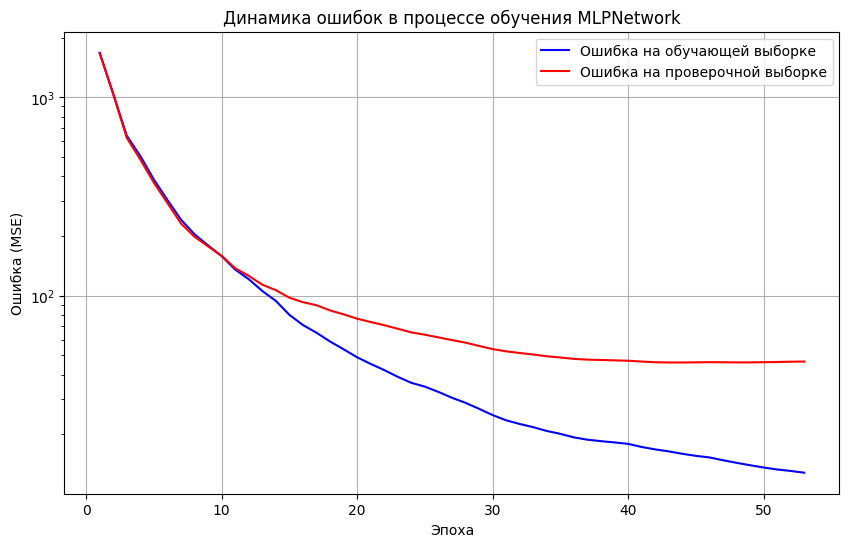

In [7]:
# Визуализация метрик обучения и валидации
import matplotlib.pyplot as plt
import numpy as np

# Получаем данные об ошибках обучения и валидации
train_losses = errors['train_losses']
test_losses = errors['test_losses']

# Создаем массив эпох
epochs = np.arange(1, len(train_losses) + 1)

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Ошибка на обучающей выборке', color='blue')
plt.plot(epochs, test_losses, label='Ошибка на проверочной выборке', color='red')
plt.title('Динамика ошибок в процессе обучения MLPNetwork')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (MSE)')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Используем логарифмическую шкалу для лучшей визуализации
plt.show()

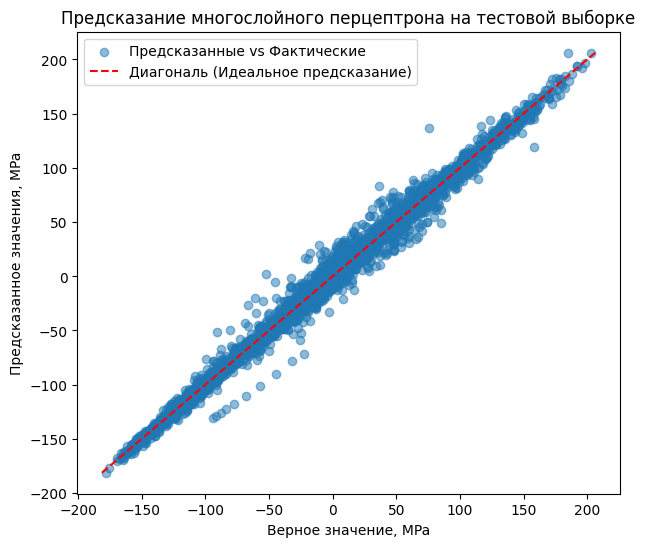

In [8]:
# Визуализация результатов предсказания модели
import numpy as np
import matplotlib.pyplot as plt
from analysis_functions import clean_input_array

# Применяем обученную модель к тестовым данным
X_test, y_test, _, _, _, _ = split_transform_one_comp_cv(
    X_current, y_current, n_splits=1
)
X_test, y_test = clean_input_array(X_test, y_test)

# Получаем предсказания
predictions = predict_with_model(model, X_test, mean, std)

# Строим график сравнения предсказанных и фактических значений
plt.figure(figsize=(7, 6))
plt.scatter(y_test, predictions, alpha=0.5, label="Предсказанные vs Фактические")

# Добавляем диагональную линию (идеальное предсказание)
min_val = min(np.min(y_test), np.min(predictions))
max_val = max(np.max(y_test), np.max(predictions))
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "r--",
    label="Диагональ (Идеальное предсказание)",
)

plt.title("Предсказание многослойного перцептрона на тестовой выборке")
plt.xlabel("Верное значение, MPa")
plt.ylabel("Предсказанное значения, MPa")
plt.legend()
# plt.grid(True)
plt.savefig(f"best_mlp_prediction_{component_num}.png", dpi=400)
plt.show()


## Анализ важности признаков

Анализ важности признаков для нейронной сети поможет определить, какие входные параметры оказывают наибольшее влияние на предсказания модели многослойного перцептрона.

In [9]:
# Создание класса-обертки для модели PyTorch для совместимости с API sklearn
from sklearn.base import BaseEstimator, RegressorMixin

class TorchModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model, mean, std):
        self.model = model
        self.mean = mean
        self.std = std
        # Переключаем модель в режим оценки
        self.model.eval()
        
    def fit(self, X, y):
        # Dummy method, не нужна реальная реализация для permutation_importance
        return self
        
    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        # Нормализация данных
        X_normalized = (X_tensor - self.mean) / self.std
        with torch.no_grad():
            y_pred = self.model(X_normalized).numpy()
        return y_pred

# Создаем экземпляр класса-обертки
model_wrapper = TorchModelWrapper(model, mean, std)

# Проверка работоспособности
sample_predictions = model_wrapper.predict(X_test[:5])
print("\nПример предсказаний через класс-обертку:")
print(sample_predictions[:5])

# Сравнение с оригинальными предсказаниями
original_predictions = predict_with_model(model, X_test[:5], mean, std)
print("\nОригинальные предсказания:")
print(original_predictions[:5])


Пример предсказаний через класс-обертку:
[[-55.740765]
 [-49.04587 ]
 [-42.82149 ]
 [-36.55554 ]
 [-29.301983]]

Оригинальные предсказания:
[[-55.740765]
 [-49.04587 ]
 [-42.82149 ]
 [-36.55554 ]
 [-29.301983]]


Расчет permutation importance (может занять некоторое время)...
Время выполнения: 10.29 секунд


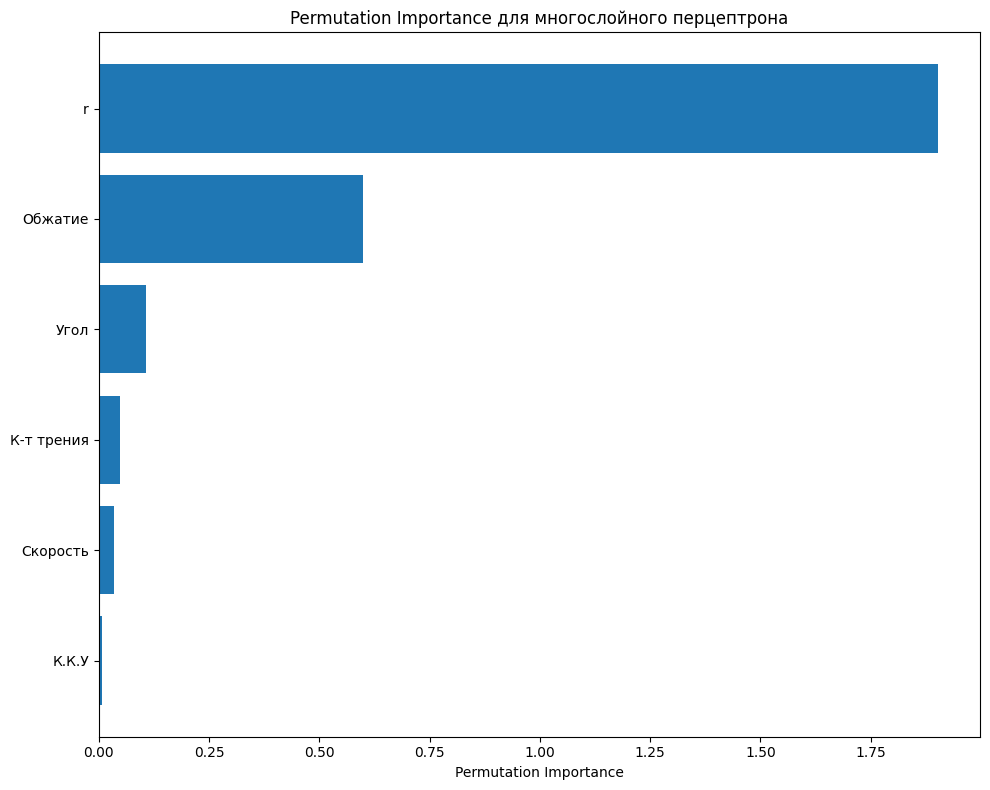

In [10]:
# Анализ важности признаков с помощью permutation importance
from sklearn.inspection import permutation_importance
import time

# Задаём названия признаков
feature_names = [
    'Обжатие',        # Признак 1
    'К.К.У',          # Признак 2
    'Угол',           # Признак 3
    'К-т трения',     # Признак 4
    'Скорость',       # Признак 5
    'r',              # Признак 6
]

# Подготовка модели и данных для анализа важности признаков
model.eval()  # Переключаем модель в режим оценки

print("Расчет permutation importance (может занять некоторое время)...")
start_time = time.time()

# Функция для предсказания, адаптированная для совместимости со sklearn
def mlp_predict(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    # Нормализация данных
    X_normalized = (X_tensor - mean) / std
    with torch.no_grad():
        y_pred = model(X_normalized).numpy()
    return y_pred

# Выполнение permutation importance на тестовых данных
r_perm = permutation_importance(
    TorchModelWrapper(model, mean, std),
    X_test,
    y_test.reshape(-1, 1),
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} секунд")

# Сортировка результатов
perm_sorted_idx = r_perm.importances_mean.argsort()

# Визуализация permutation importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(perm_sorted_idx)), r_perm.importances_mean[perm_sorted_idx])
plt.yticks(range(len(perm_sorted_idx)), [feature_names[i] for i in perm_sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance для многослойного перцептрона')
plt.tight_layout()
plt.savefig(f'permutation_importance_mlp_{component_num}.png', dpi=400)
plt.show()

In [11]:
# Создаем DataFrame с результатами важности признаков
import pandas as pd

importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': r_perm.importances_mean,
    'Стандартное отклонение': r_perm.importances_std
})

# Сортировка по важности
importance_df = importance_df.sort_values('Важность', ascending=False)

# Вывод результатов
print("Важность признаков для модели MLP:")
print(importance_df.to_string(index=False))

# Топ признаков
print("\nТоп 3 самых важных признака:")
for i, row in importance_df.head(3).iterrows():
    print(f"{row['Признак']}: {row['Важность']:.4f} ± {row['Стандартное отклонение']:.4f}")

Важность признаков для модели MLP:
   Признак  Важность  Стандартное отклонение
         r  1.902917                0.027035
   Обжатие  0.598576                0.012079
      Угол  0.108075                0.002262
К-т трения  0.047216                0.001580
  Скорость  0.034748                0.001544
     К.К.У  0.006444                0.000209

Топ 3 самых важных признака:
r: 1.9029 ± 0.0270
Обжатие: 0.5986 ± 0.0121
Угол: 0.1081 ± 0.0023


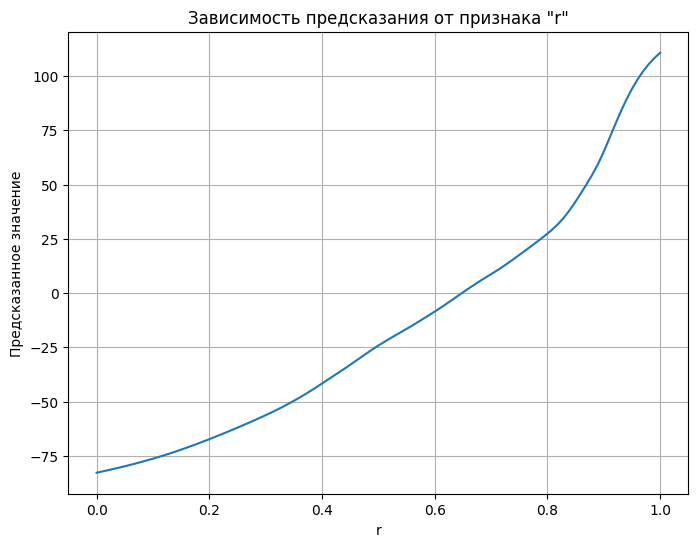

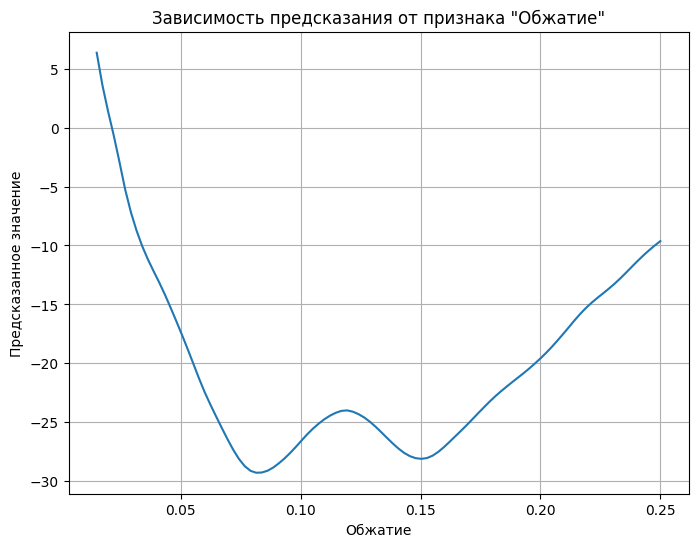

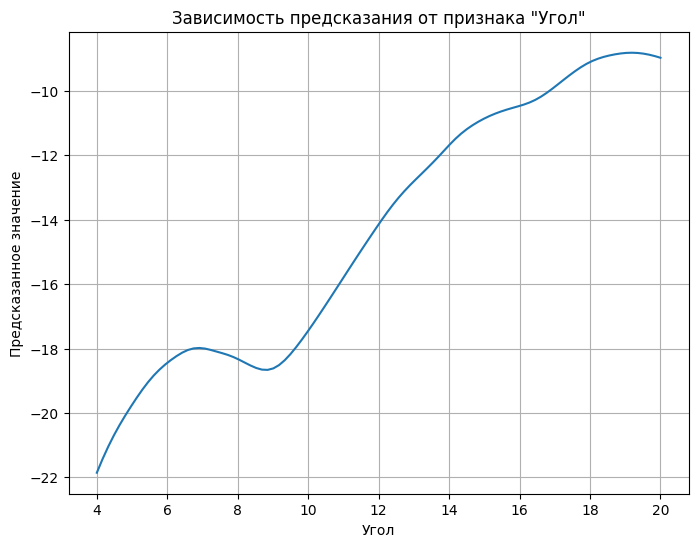

In [12]:
# Анализ зависимости предсказаний от значений самых важных признаков
import matplotlib.pyplot as plt
import numpy as np

# Выбираем топ-3 самых важных признака
top_features = importance_df['Признак'].head(3).tolist()
top_indices = [feature_names.index(feat) for feat in top_features]

# Функция для создания графика зависимости
def plot_feature_effect(feature_idx, feature_name):
    # Создаем диапазон значений для признака
    X_sample = X_test.copy()
    feature_min = np.min(X_test[:, feature_idx])
    feature_max = np.max(X_test[:, feature_idx])
    feature_range = np.linspace(feature_min, feature_max, 100)
    
    # Получаем предсказания для разных значений признака
    predictions = []
    for val in feature_range:
        X_modified = X_sample.copy()
        X_modified[:, feature_idx] = val
        preds = mlp_predict(X_modified)
        predictions.append(np.mean(preds))
    
    # Строим график
    plt.figure(figsize=(8, 6))
    plt.plot(feature_range, predictions)
    plt.xlabel(feature_name)
    plt.ylabel('Предсказанное значение')
    plt.title(f'Зависимость предсказания от признака "{feature_name}"')
    plt.grid(True)
    plt.savefig(f'feature_effect_mlp_{component_num}_{feature_name}.png', dpi=400)
    plt.show()

# Строим графики для топ-3 признаков
for idx, name in zip(top_indices, top_features):
    plot_feature_effect(idx, name)

/var/folders/_d/tbsnrdk10zg3j0zy12r9dprw0000gq/T/ipykernel_4786/818745960.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions[j, i] = mlp_predict(X_modified)[0]


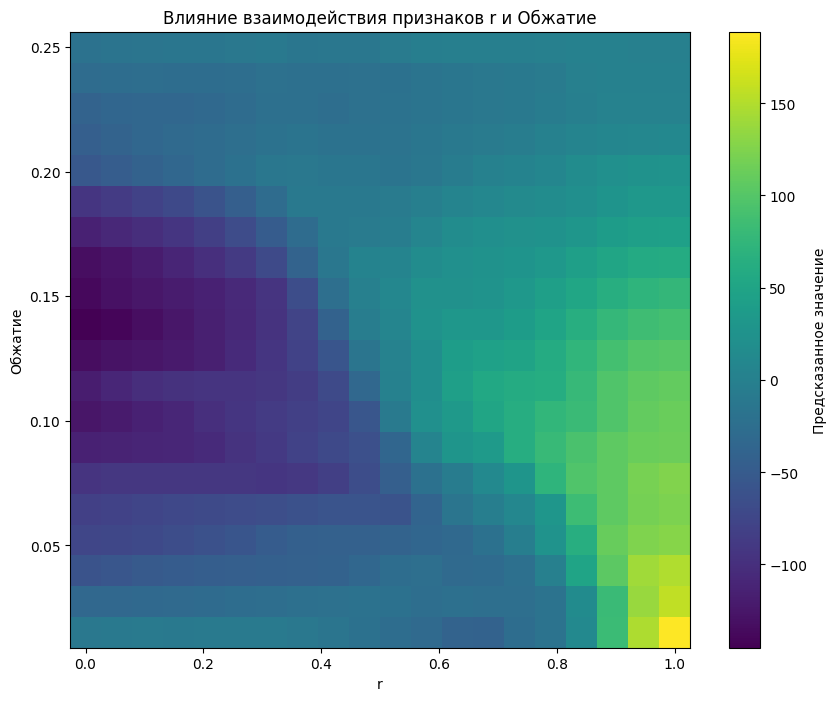

In [13]:
# Визуализация взаимодействия двух самых важных признаков
if len(top_indices) >= 2:
    # Выбираем два самых важных признака
    idx1, idx2 = top_indices[0], top_indices[1]
    name1, name2 = top_features[0], top_features[1]
    
    # Создаем сетку значений
    feature1_min = np.min(X_test[:, idx1])
    feature1_max = np.max(X_test[:, idx1])
    feature2_min = np.min(X_test[:, idx2])
    feature2_max = np.max(X_test[:, idx2])
    
    x1_grid = np.linspace(feature1_min, feature1_max, 20)
    x2_grid = np.linspace(feature2_min, feature2_max, 20)
    xx, yy = np.meshgrid(x1_grid, x2_grid)
    
    # Получаем предсказания для разных комбинаций значений признаков
    predictions = np.zeros_like(xx)
    for i in range(len(x1_grid)):
        for j in range(len(x2_grid)):
            X_modified = np.tile(X_test[0], (1, 1))
            X_modified[0, idx1] = x1_grid[i]
            X_modified[0, idx2] = x2_grid[j]
            predictions[j, i] = mlp_predict(X_modified)[0]
    
    # Строим тепловую карту
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, predictions, cmap='viridis', shading='auto')
    plt.colorbar(label='Предсказанное значение')
    plt.xlabel(name1)
    plt.ylabel(name2)
    plt.title(f'Влияние взаимодействия признаков {name1} и {name2}')
    plt.savefig(f'feature_interaction_mlp_{component_num}.png', dpi=400)
    plt.show()

## Выводы по анализу важности признаков

Анализ важности признаков с помощью метода пермутационной важности (permutation importance) позволяет определить, какие входные параметры оказывают наибольшее влияние на предсказания модели многослойного перцептрона.

Высокие значения важности означают, что случайное перемешивание значений этого признака приводит к значительному ухудшению качества предсказаний модели, что свидетельствует о высокой важности данного признака.

Также были проанализированы частичные зависимости для топ признаков, чтобы понять характер влияния каждого из них на предсказания модели, и визуализировано взаимодействие между двумя самыми важными признаками.